## <font color="red">*Exercise 1*</font>

<font color="red">Construct cells immediately below this that construct features and cluster your documents using K-means and a variety of cluster numbers. Interrogate the cluster contents in terms of both documents and features. Identify the "optimal" cluster number with Silhouette analysis. Plot clusters and features after reducing with PCA. What does this cluster structure reveal about the organization of documents in your corpora? 

Among all cluster numbers I tried, 20 performed best regarding Silhouette score. 

I fitted k-means models of 4 clusters and 20 clusters respectively.

It seems the financial news are clustered around discussions about the Covid-19 pandemic, US-China trade war, and company-specific announcements.

In [1]:
import os
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git


#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas as pd#gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json

In [2]:
data = pd.read_csv('reuters_headlines.csv')

In [3]:
data['Time']

0        Jul 18 2020
1        Jul 18 2020
2        Jul 18 2020
3        Jul 18 2020
4        Jul 17 2020
            ...     
32765    Mar 20 2018
32766    Mar 20 2018
32767    Mar 20 2018
32768    Mar 20 2018
32769    Mar 20 2018
Name: Time, Length: 32770, dtype: object

In [5]:
data['year'] = pd.DatetimeIndex(data['Time']).year

In [6]:
data

,Headlines,Time,Description,year
0,TikTok considers London and other locations fo...,Jul 18 2020,TikTok has been in discussions with the UK gov...,2020
1,Disney cuts ad spending on Facebook amid growi...,Jul 18 2020,Walt Disney has become the latest company to ...,2020
2,Trail of missing Wirecard executive leads to B...,Jul 18 2020,Former Wirecard chief operating officer Jan M...,2020
3,Twitter says attackers downloaded data from up...,Jul 18 2020,Twitter Inc said on Saturday that hackers were...,2020
4,U.S. Republicans seek liability protections as...,Jul 17 2020,A battle in the U.S. Congress over a new coron...,2020
...,...,...,...,...
32765,Malaysia says never hired British data firm at...,Mar 20 2018,The Malaysian government and the ruling party ...,2018
32766,Prosecutors search Volkswagen headquarters in ...,Mar 20 2018,German prosecutors said on Tuesday they had se...,2018
32767,McDonald's sets greenhouse gas reduction targets,Mar 20 2018,McDonald's Corp on Tuesday announced an approv...,2018
32768,Pratt & Whitney to deliver spare A320neo engin...,Mar 20 2018,Pratt & Whitney will soon begin deliveries of ...,2018


In [9]:
#First it needs to be initialized
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
#Then trained
DescriptionVects = ngCountVectorizer.fit_transform(data['Description'])
print(DescriptionVects.shape) #2350 documents, 23525 words

(32770, 26309)


In [13]:
DescriptionVects.toarray()[:11, :11]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [14]:
ngCountVectorizer.vocabulary_.get('vector')

In [16]:
DescriptionTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(DescriptionVects)
#train
DescriptionTF = newsgroupsTFTransformer.transform(DescriptionVects)
print(DescriptionTF.shape)


(32770, 26309)


In [17]:
list(zip(ngCountVectorizer.vocabulary_.keys(), DescriptionTF.data))[:20]

[('tiktok', 0.16847810009716904),
 ('has', 0.21006825039464597),
 ('been', 0.09474934231244267),
 ('in', 0.26774615930257367),
 ('discussions', 0.12069835365559217),
 ('with', 0.20299657170927143),
 ('the', 0.18082381458879845),
 ('uk', 0.06396028104648992),
 ('government', 0.2063482846754307),
 ('over', 0.16521354510470854),
 ('past', 0.2492246004624857),
 ('few', 0.12056769421705266),
 ('months', 0.053685321572991156),
 ('to', 0.16171287527974457),
 ('locate', 0.14028464352537193),
 ('its', 0.1904415330936461),
 ('headquarters', 0.32551755384985226),
 ('london', 0.22633467897015805),
 ('source', 0.1457500706395104),
 ('familiar', 0.11209395415332926)]

In [10]:
#initialize
ngTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
#initialize
DescriptionTFVects = ngTFVectorizer.fit_transform(data['Description'])

In [19]:
len(ngTFVectorizer.vocabulary_)

1000

In [20]:
km = sklearn.cluster.KMeans(n_clusters=4, init='k-means++')

In [21]:
km.fit(DescriptionTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [22]:
data['4_kmeans_predictions'] = km.labels_
data

,Headlines,Time,Description,4_kmeans_predictions
0,TikTok considers London and other locations fo...,Jul 18 2020,TikTok has been in discussions with the UK gov...,3
1,Disney cuts ad spending on Facebook amid growi...,Jul 18 2020,Walt Disney has become the latest company to ...,3
2,Trail of missing Wirecard executive leads to B...,Jul 18 2020,Former Wirecard chief operating officer Jan M...,2
3,Twitter says attackers downloaded data from up...,Jul 18 2020,Twitter Inc said on Saturday that hackers were...,3
4,U.S. Republicans seek liability protections as...,Jul 17 2020,A battle in the U.S. Congress over a new coron...,3
...,...,...,...,...
32765,Malaysia says never hired British data firm at...,Mar 20 2018,The Malaysian government and the ruling party ...,3
32766,Prosecutors search Volkswagen headquarters in ...,Mar 20 2018,German prosecutors said on Tuesday they had se...,3
32767,McDonald's sets greenhouse gas reduction targets,Mar 20 2018,McDonald's Corp on Tuesday announced an approv...,3
32768,Pratt & Whitney to deliver spare A320neo engin...,Mar 20 2018,Pratt & Whitney will soon begin deliveries of ...,3


In [23]:
terms = ngTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]#why
for i in range(4):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 trade
 trump
 president
 donald
 china
 states
 united
 tariffs
 said
 chinese


Cluster 1:
 oil
 year
 coronavirus
 quarter
 reserve
 federal
 global
 growth
 economy
 prices


Cluster 2:
 chief
 executive
 officer
 said
 company
 new
 wednesday
 tuesday
 bank
 financial


Cluster 3:
 said
 billion
 company
 tuesday
 thursday
 wednesday
 monday
 new
 group
 friday




In [25]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(DescriptionTFVects.toarray())
reduced_data = pca.transform(DescriptionTFVects.toarray())

In [26]:
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

In [34]:
#colors_p = [colordict[newsgroupsCategories[l]] for l in km.labels_]
colors_p = ['red', 'orange', 'green', 'blue']

colors = [colors_p[i-1] for i in km.labels_]

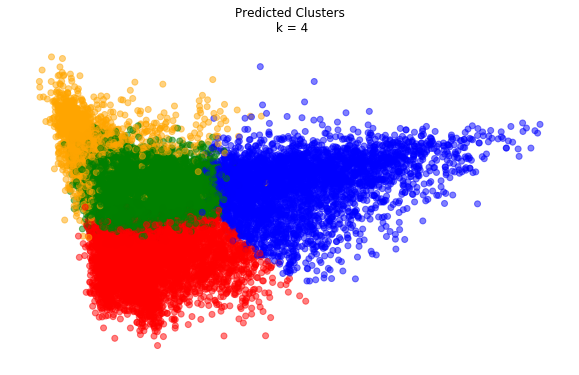

In [36]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 4')
plt.show()

In [37]:
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


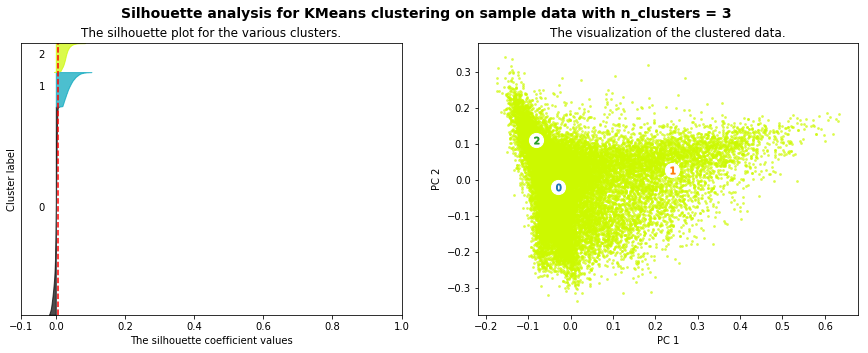

For n_clusters = 3, The average silhouette_score is : 0.007


In [38]:
X = DescriptionTFVects.toarray()
plotSilhouette(3, X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


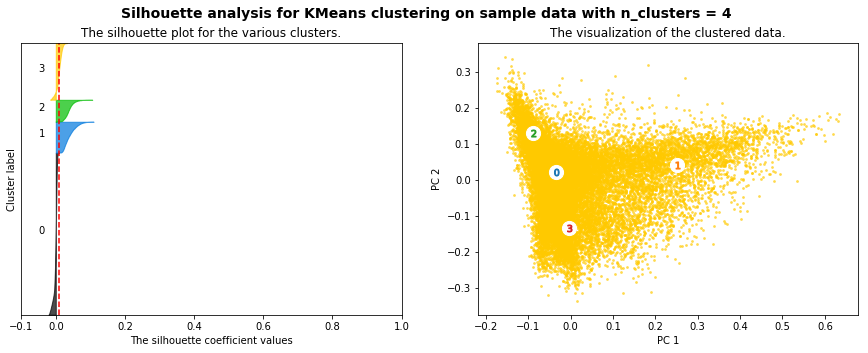

For n_clusters = 4, The average silhouette_score is : 0.009


In [39]:
X = DescriptionTFVects.toarray()
plotSilhouette(4, X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


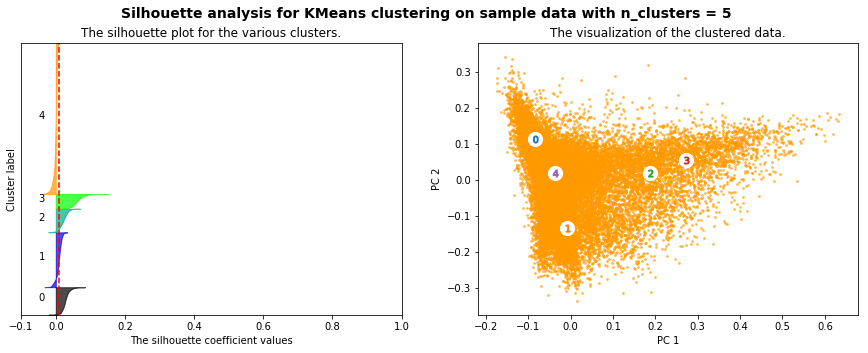

For n_clusters = 5, The average silhouette_score is : 0.009


In [40]:
X = DescriptionTFVects.toarray()
plotSilhouette(5, X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


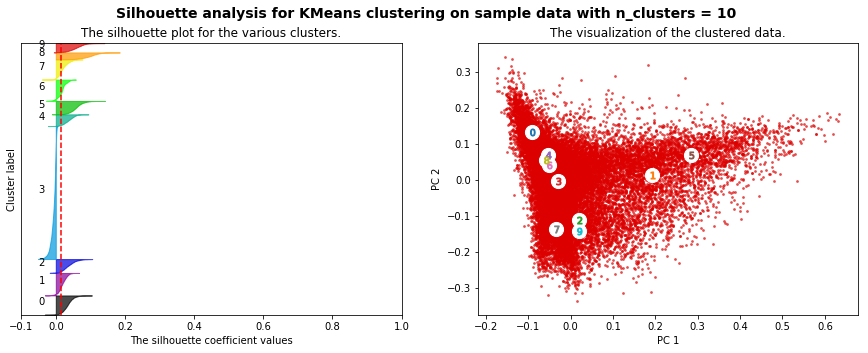

For n_clusters = 10, The average silhouette_score is : 0.015


In [41]:
X = DescriptionTFVects.toarray()
plotSilhouette(10, X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


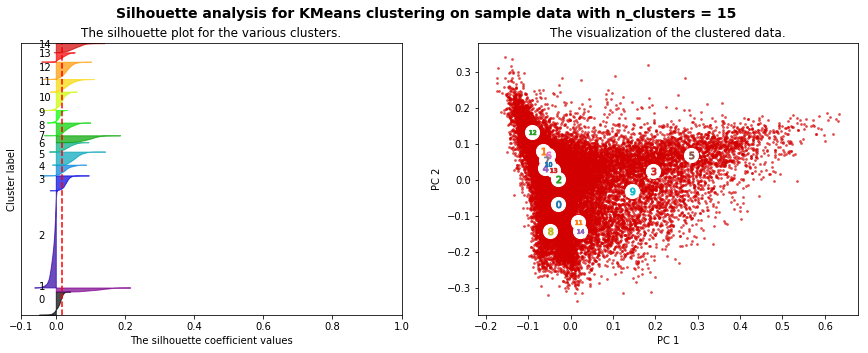

For n_clusters = 15, The average silhouette_score is : 0.018


In [42]:
X = DescriptionTFVects.toarray()
plotSilhouette(15, X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


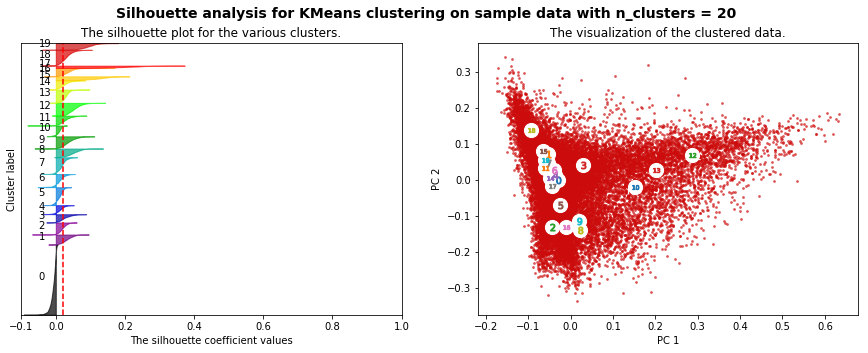

For n_clusters = 20, The average silhouette_score is : 0.021


In [43]:
X = DescriptionTFVects.toarray()
plotSilhouette(20, X)

In [44]:
km20 = sklearn.cluster.KMeans(n_clusters=20, init='k-means++')

In [45]:
km20.fit(DescriptionTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=20, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [49]:
data['20_kmeans_predictions'] = km20.labels_
data

,Headlines,Time,Description,year,tokenized_text,normalized_tokens,reduced_tokens,20_kmeans_predictions
0,TikTok considers London and other locations fo...,Jul 18 2020,TikTok has been in discussions with the UK gov...,2020,"[TikTok, has, been, in, discussions, with, the...","[tiktok, discussion, uk, government, past, mon...","[uk, government, past, month, london, source, ...",13
1,Disney cuts ad spending on Facebook amid growi...,Jul 18 2020,Walt Disney has become the latest company to ...,2020,"[Walt, Disney, has, become, the, latest, compa...","[walt, disney, late, company, slash, advertise...","[walt, disney, late, company, facebook, social...",13
2,Trail of missing Wirecard executive leads to B...,Jul 18 2020,Former Wirecard chief operating officer Jan M...,2020,"[Former, Wirecard, chief, operating, officer, ...","[wirecard, chief, operate, officer, jan, marsa...","[chief, officer, travel, soon, russia, german,...",3
3,Twitter says attackers downloaded data from up...,Jul 18 2020,Twitter Inc said on Saturday that hackers were...,2020,"[Twitter, Inc, said, on, Saturday, that, hacke...","[twitter, inc, say, saturday, hacker, able, do...","[twitter, say, saturday, information, week, say]",9
4,U.S. Republicans seek liability protections as...,Jul 17 2020,A battle in the U.S. Congress over a new coron...,2020,"[A, battle, in, the, U.S., Congress, over, a, ...","[battle, u.s, congress, new, coronavirus, aid,...","[battle, congress, new, coronavirus, aid, begi...",11
...,...,...,...,...,...,...,...,...
32765,Malaysia says never hired British data firm at...,Mar 20 2018,The Malaysian government and the ruling party ...,2018,"[The, Malaysian, government, and, the, ruling,...","[malaysian, government, rule, party, tuesday, ...","[government, tuesday, british, firm, personal,...",9
32766,Prosecutors search Volkswagen headquarters in ...,Mar 20 2018,German prosecutors said on Tuesday they had se...,2018,"[German, prosecutors, said, on, Tuesday, they,...","[german, prosecutor, say, tuesday, search, vol...","[german, say, tuesday, volkswagen, new, invest...",9
32767,McDonald's sets greenhouse gas reduction targets,Mar 20 2018,McDonald's Corp on Tuesday announced an approv...,2018,"[McDonald, 's, Corp, on, Tuesday, announced, a...","[mcdonald, corp, tuesday, announce, approve, s...","[corp, tuesday, target, cut, gas, battle, chan...",9
32768,Pratt & Whitney to deliver spare A320neo engin...,Mar 20 2018,Pratt & Whitney will soon begin deliveries of ...,2018,"[Pratt, Whitney, will, soon, begin, deliveries...","[pratt, whitney, soon, begin, delivery, spare,...","[soon, begin, delivery, engine, india, airline...",13


In [47]:
terms = ngTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km20.cluster_centers_.argsort()[:, ::-1]#why
for i in range(20):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 profit
 quarterly
 estimates
 quarter
 forecast
 revenue
 shares
 sales
 reported
 sending


Cluster 1:
 trade
 states
 china
 united
 said
 war
 tariffs
 chinese
 talks
 deal


Cluster 2:
 president
 donald
 trump
 trade
 tariffs
 china
 said
 chinese
 deal
 states


Cluster 3:
 chief
 executive
 officer
 said
 company
 new
 musk
 elon
 tesla
 tuesday


Cluster 4:
 saudi
 arabia
 oil
 aramco
 said
 russia
 facilities
 opec
 output
 state


Cluster 5:
 oil
 prices
 crude
 opec
 energy
 output
 demand
 global
 gas
 producers


Cluster 6:
 european
 union
 said
 eu
 britain
 trade
 workers
 united
 tariffs
 commission


Cluster 7:
 stocks
 street
 wall
 investors
 stock
 global
 500
 market
 trade
 economic


Cluster 8:
 737
 boeing
 max
 aircraft
 airlines
 aviation
 grounded
 crashes
 said
 jets


Cluster 9:
 said
 company
 new
 tuesday
 wednesday
 thursday
 monday
 group
 friday
 corp


Cluster 10:
 nissan
 ghosn
 carlos
 renault
 motor
 chairman
 al

## <font color="red">*Exercise 2*</font>

<font color="red">Construct cells immediately below this that hierarchically cluster your documents using two approaches, and visualize them with a tree. Interrogate the recursive cluster contents in terms of both documents and closenesses. What does this nested cluster structure reveal about the organization of documents in your sampled corpora? Moreover, if they do worse than kmeans (as above), why do you think this is the case (hint: using metrics if you have ground truth or silhouette if you do not)? 

<font color="red">***Stretch***: Attempt using different distances into your clustering algorithms. (How) do they change the arrangement of clusters?

In [11]:
CoocMat = DescriptionTFVects * DescriptionTFVects.T
CoocMat.setdiag(0)

/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [12]:
CoocMat

<32770x32770 sparse matrix of type '<class 'numpy.float64'>'
	with 452512278 stored elements in Compressed Sparse Row format>

In [7]:
selectIndices = []
indexToCat = []
for c in set(data['year']):
    selectIndices += list(data[data['year'] == c].index)[:50]
    indexToCat += [c] * 500
    #.groupby('category').sum()

In [13]:
subCoocMat = CoocMat[selectIndices,:][:,selectIndices]

In [14]:
linkage_matrix = scipy.cluster.hierarchy.ward(subCoocMat.toarray())
linkage_matrix[:10]

/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


array([[ 81.        , 121.        ,   0.35075365,   2.        ],
       [ 35.        , 148.        ,   0.36556014,   2.        ],
       [ 29.        , 127.        ,   0.39117718,   2.        ],
       [ 10.        ,  41.        ,   0.39292217,   2.        ],
       [ 79.        , 106.        ,   0.42131581,   2.        ],
       [ 52.        , 151.        ,   0.42752177,   3.        ],
       [116.        , 123.        ,   0.44395703,   2.        ],
       [ 96.        , 156.        ,   0.45808568,   3.        ],
       [ 55.        ,  86.        ,   0.45904282,   2.        ],
       [137.        , 154.        ,   0.46232816,   3.        ]])

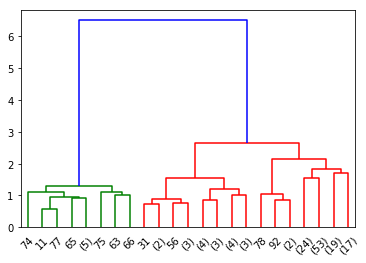

In [21]:
dendrogramDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=4, truncate_mode='level', get_leaves=True)

In [22]:
hierarchicalClusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, 4, 'maxclust')
hierarchicalClusters

array([2, 4, 4, 4, 2, 4, 4, 4, 3, 4, 4, 1, 4, 4, 4, 2, 2, 4, 2, 4, 4, 4,
       4, 4, 4, 2, 4, 4, 2, 4, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 2, 4, 2, 4, 4, 4, 2, 4, 4, 2, 4, 4, 4, 3, 4, 1, 1, 4, 1,
       1, 1, 4, 4, 4, 1, 4, 1, 1, 1, 1, 1, 3, 4, 4, 4, 4, 4, 2, 2, 4, 2,
       4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 2, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4], dtype=int32)

## <font color="red">*Exercise 3*</font>

<font color="red">Construct cells immediately below this that topic model documents related to your anticipated final project. Interrogate and visually plot (e.g., as a bar graph?) the topic-word loadings and the document-topic loadings. What does this topic structure reveal about the distribution of contents across your documents? Systematically vary the $\alpha$, $\eta$, and topic number of the model for your text and describe in detail whether and how these changes led to distinctive outcomes, visible to you as analyst.  

<font color="red">**Stretch**: Cluster your documents, but instead of using words alone, use their topic loadings as an additional set of features. Do these topic loadings increase the apparent semantic coherence of your clusters?</font> 

We can spot several interesting distinct topics here: for example, topic_1 is about the macro economy and policies, topic_6 is about the aviation industry, topic_7 talks about the trade war between US and China, topic_8 focuses on the stock market.

In [23]:
data['tokenized_text'] = data['Description'].apply(lambda x: lucem_illud.word_tokenize(x))
data['normalized_tokens'] = data['Description'].apply(lambda x: lucem_illud.normalizeTokens(x))

In [24]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

data['reduced_tokens'] = data['normalized_tokens'].apply(lambda x: dropMissing(x, ngTFVectorizer.vocabulary_.keys()))

In [25]:
dictionary = gensim.corpora.Dictionary(data['reduced_tokens'])
corpus = [dictionary.doc2bow(text) for text in data['reduced_tokens']]
gensim.corpora.MmCorpus.serialize('senate.mm', corpus)
senmm = gensim.corpora.MmCorpus('senate.mm')

In [27]:
newslda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')


In [30]:
news1Bow = dictionary.doc2bow(data['reduced_tokens'][0])
news1lda = newslda[news1Bow]
print("The topics of the text: {}".format(data['Headlines'][0]))
print("are: {}".format(news1lda))

The topics of the text: TikTok considers London and other locations for headquarters
are: [(3, 0.46461082), (5, 0.15351525), (6, 0.20001219), (8, 0.1405578)]


In [31]:
ldaDF = pd.DataFrame({
        'name' : data['Headlines'],
        'topics' : [newslda[dictionary.doc2bow(l)] for l in data['reduced_tokens']]
    })

In [33]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(newslda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(newslda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF[1::100]

,name,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
1,Disney cuts ad spending on Facebook amid growi...,"[(0, 0.7477855), (3, 0.21399783)]",0.747786,0.000000,0.000000,0.213998,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
101,"EU regulators to probe Alexa, Siri and other v...","[(0, 0.20820107), (2, 0.7412183)]",0.208201,0.000000,0.741218,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
201,Factbox: Semi-automated driving systems: Not a...,"[(0, 0.014775566), (2, 0.53877217), (3, 0.0124...",0.014776,0.000000,0.538772,0.012458,0.014133,0.012671,0.013344,0.357205,0.016177,0.010776
301,"Faced with COVID-19, highest number of Austral...","[(0, 0.21581697), (1, 0.50445366), (8, 0.23507...",0.215817,0.504454,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.235078,0.000000
401,Credit Suisse settles U.S. shareholder lawsuit...,"[(3, 0.4810626), (4, 0.19483824), (5, 0.285360...",0.000000,0.000000,0.000000,0.481063,0.194838,0.285361,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
32301,Exchange operator CME Group to buy Britain's N...,"[(4, 0.5972242), (9, 0.36106253)]",0.000000,0.000000,0.000000,0.000000,0.597224,0.000000,0.000000,0.000000,0.000000,0.361063
32401,British VW drivers start 'dieselgate' claim in...,"[(2, 0.47930926), (3, 0.31296286), (5, 0.17579...",0.000000,0.000000,0.479309,0.312963,0.000000,0.175794,0.000000,0.000000,0.000000,0.000000
32501,"Facebook: call, text history logging requires ...","[(0, 0.5449148), (2, 0.0102095455), (4, 0.0104...",0.544915,0.000000,0.010210,0.000000,0.010490,0.000000,0.378125,0.010413,0.012006,0.000000
32601,Goldman Sachs CEO calls reports of pending ret...,"[(0, 0.25783506), (5, 0.69848263)]",0.257835,0.000000,0.000000,0.000000,0.000000,0.698483,0.000000,0.000000,0.000000,0.000000


In [34]:
ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(10)]]
ldaDFVisN = ldaDF[:10][['name']]
#ldaDFVis = ldaDFV.as_matrix(columns=None)
#ldaDFVisNames = ldaDFVisN.as_matrix(columns=None) 
ldaDFV

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.000000,0.000000,0.000000,0.464754,0.000000,0.153486,0.199877,0.000000,0.140579,0.000000
1,0.747786,0.000000,0.000000,0.213998,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.492025,0.438416,0.000000,0.010636,0.000000
3,0.501616,0.000000,0.011720,0.010615,0.012043,0.010797,0.410036,0.011954,0.013783,0.000000
4,0.000000,0.425361,0.132461,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.398120
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.938098,0.000000
6,0.219401,0.000000,0.208364,0.010615,0.012042,0.010797,0.011370,0.011954,0.498021,0.000000
7,0.000000,0.707128,0.000000,0.243369,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.635001,0.152406,0.166732,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.403537,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.426822,0.132503


In [35]:
ldaDFVis = np.array(ldaDFV)
ldaDFVisNames = np.array(ldaDFVisN)

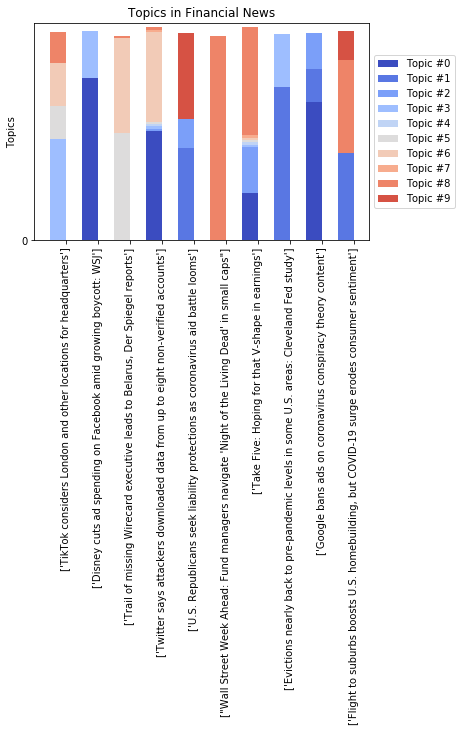

In [36]:
N = 10
ind = np.arange(N)
K = senlda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Financial News')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


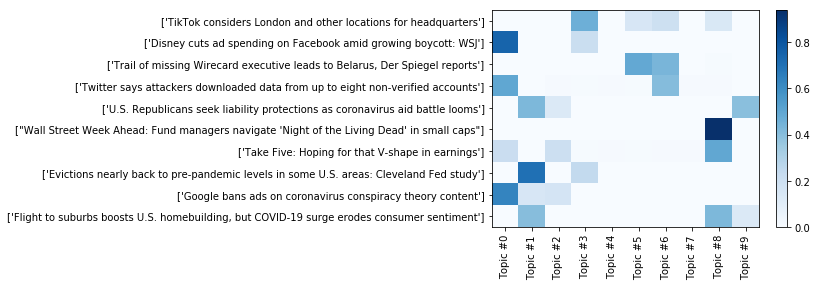

In [37]:
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

In [39]:
topicsDict = {}
for topicNum in range(newslda.num_topics):
    topicWords = [w for w, p in newslda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pd.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,company,federal,say,say,percent,executive,say,trade,stock,say
1,say,rate,european,company,say,chief,airline,china,high,trump
2,corp,reserve,bank,court,company,say,minister,tariff,trade,administration
3,facebook,bank,union,tuesday,sale,officer,steel,state,price,president
4,report,economy,car,technology,business,group,boeing,say,market,house
5,technology,consumer,vehicle,tesla,year,bank,jet,president,year,donald
6,new,policy,motor,maker,big,company,oil,trump,share,exchange
7,group,central,german,chinese,large,board,airbus,donald,quarter,white
8,fund,say,electric,firm,buy,new,source,chinese,rise,tuesday
9,firm,market,model,thursday,share,french,air,thursday,global,secretary


<Figure size 432x288 with 0 Axes>

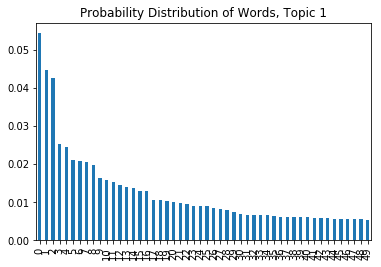

In [41]:
topic1_df = pd.DataFrame(newslda.show_topic(1, topn=50))
plt.figure()
topic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1')
plt.show()

In [42]:
newslda1 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.00001)
newslda2 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.9)

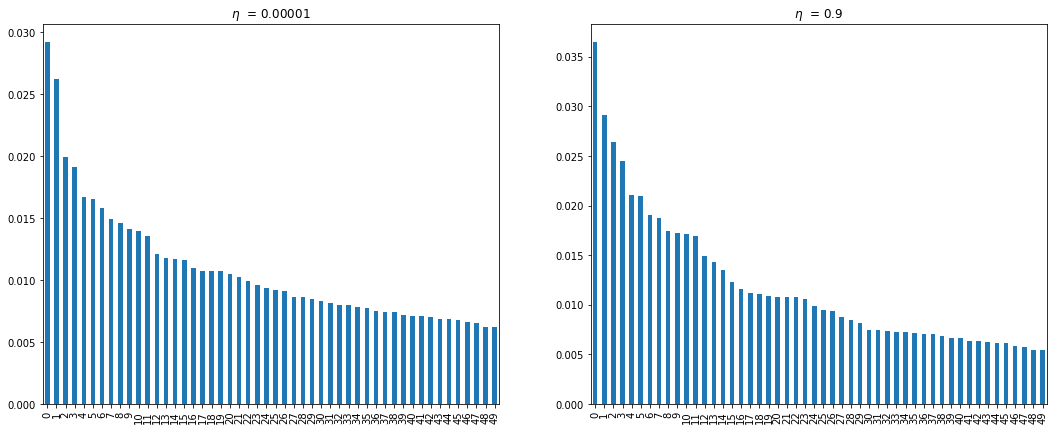

In [43]:
topic11_df = pd.DataFrame(newslda1.show_topic(1, topn=50))
topic21_df = pd.DataFrame(newslda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001')
topic21_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')
plt.show()



## <font color="red">*Exercise 4*</font>

<font color="red">Construct cells immediately below this that use dynamic topic models on datasets relevant to your final project. You can also extend the analysis of the COHA or Soap datasets, if relevant to the comparison of data for your projects. (You could possibly use coha_genres dictionary to conduct analysis on topic evolution for a particular genre? What themes do you see evolving throughout these corpora?)

Concerning about running time, I fit the dynamic topic model with a subset of data.

The content of the topics does not seem to change much over time.

In [85]:
df_small = data.sort_values(by=['year'])[::100]
df_small

,Headlines,Time,Description,year,tokenized_text,normalized_tokens,reduced_tokens,20_kmeans_predictions
32769,UK will always consider ways to improve data l...,Mar 20 2018,Britain will consider any suggestions to give ...,2018,"[Britain, will, consider, any, suggestions, to...","[britain, consider, suggestion, body, charge, ...","[britain, privacy, law, power, prime, minister...",9
26292,U.S. Justice Department probes Musk statement ...,Sep 18 2018,Tesla Inc said on Tuesday the U.S. Department ...,2018,"[Tesla, Inc, said, on, Tuesday, the, U.S., Dep...","[tesla, inc, say, tuesday, u.s, department, ju...","[tesla, say, tuesday, department, justice, chi...",3
25999,Musk would not give up chairman role to settle...,Sep 28 2018,Tesla Inc Chief Executive Officer Elon Musk r...,2018,"[Tesla, Inc, Chief, Executive, Officer, Elon, ...","[tesla, inc, chief, executive, officer, elon, ...","[tesla, chief, executive, officer, elon, musk,...",3
26092,Foreign airlines to face new rivals on popular...,Sep 26 2018,Foreign airlines that fly on 20 popular long-h...,2018,"[Foreign, airlines, that, fly, on, 20, popular...","[foreign, airline, fly, popular, long, haul, r...","[foreign, airline, long, china, face, fresh, p...",9
26570,China seeks WTO backing for $7 billion sanctio...,Sep 11 2018,China told the World Trade Organization (WTO) ...,2018,"[China, told, the, World, Trade, Organization,...","[china, tell, world, trade, organization, wto,...","[china, world, trade, organization, tuesday, i...",1
...,...,...,...,...,...,...,...,...
6037,Exxon pledges 'significant' spending cuts amid...,Mar 16 2020,"Exxon Mobil on Monday said it will make ""sign...",2020,"[Exxon, Mobil, on, Monday, said, it, will, mak...","[exxon, mobil, monday, say, significant, cut, ...","[monday, say, significant, cut, face, oil, pri...",5
5777,"American Airlines says bookings still falling,...",Mar 19 2020,American Airlines Group Inc is working on mor...,2020,"[American, Airlines, Group, Inc, is, working, ...","[american, airline, group, inc, work, network,...","[american, airline, group, work, network, time...",9
6244,Why Brazilian airline shares are hardest hit b...,Mar 13 2020,The airline stocks that suffered the most afte...,2020,"[The, airline, stocks, that, suffered, the, mo...","[airline, stock, suffer, u.s, president, donal...","[airline, stock, president, donald, trump, tra...",2
6270,Wall Street dazed and confused after worst day...,Mar 12 2020,As trading ended on Thursday in Wall Street's ...,2020,"[As, trading, ended, on, Thursday, in, Wall, S...","[trade, end, thursday, wall, street, wrong, da...","[trade, end, thursday, wall, street, day, deca...",7


In [97]:
df_small.iloc[80]

Headlines                Verizon to shut down award-winning go90 mobile...
Time                                                           Jun 28 2018
Description              Verizon Communications Inc is shutting down it...
year                                                                  2018
tokenized_text           [Verizon, Communications, Inc, is, shutting, d...
normalized_tokens        [verizon, communication, inc, shut, mobile, vi...
reduced_tokens           [shut, mobile, video, service, year, launch, c...
20_kmeans_predictions                                                    9
Name: 28841, dtype: object

In [86]:
dictionary_small = gensim.corpora.Dictionary(df_small['reduced_tokens'])
corpus_small = [dictionary_small.doc2bow(text) for text in df_small['reduced_tokens']]



In [87]:
final_corpus= []
docs_per_time_slice = [0, 0, 0, 0]

In [88]:
for i, article in enumerate(df_small['reduced_tokens']):
    # identify time slice based on article number 
    if i < 80:
        time = 0
    if i > 80 and i <= 160:
        time = 1
    if i > 160 and i <= 240:
        time = 2
    if i > 240:
        time = 3
        
    if len(article) > 1000:
        split_docs, no_docs = split_up(article)
        for doc in split_docs:
            final_corpus.append(doc)
        docs_per_time_slice[time] += no_docs
    else:
        final_corpus.append(article)
        docs_per_time_slice[time] += 1
    # just a check if the counts are correctly added
    if np.sum(docs_per_time_slice) != len(final_corpus):
        print(np.sum(docs_per_time_slice), len(final_corpus))

In [91]:
dictionary = gensim.corpora.Dictionary(final_corpus)
corpus = [dictionary.doc2bow(text) for text in final_corpus]
gensim.corpora.MmCorpus.serialize('coha.mm', corpus)
cohacorpus = gensim.corpora.MmCorpus('coha.mm')

In [92]:
from gensim.models import ldaseqmodel
ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=docs_per_time_slice, num_topics=4)

/anaconda3/lib/python3.7/site-packages/gensim/models/ldaseqmodel.py:293: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


In [95]:
ldaseq.print_topics(time=0)

[[('say', 0.039084566110626086),
  ('oil', 0.026803700294309916),
  ('price', 0.01888872061728616),
  ('monday', 0.016228850054105674),
  ('corp', 0.014752705545855383),
  ('wednesday', 0.014568625721584617),
  ('thursday', 0.013865872078568757),
  ('tuesday', 0.012876611717720879),
  ('motor', 0.012667187031117874),
  ('crude', 0.012550486047346456),
  ('plan', 0.011772287524639042),
  ('year', 0.010824810457246464),
  ('coronavirus', 0.010511378896472103),
  ('court', 0.010364769078000585),
  ('demand', 0.010225355286985855),
  ('department', 0.00985971756807155),
  ('market', 0.009682610373348435),
  ('high', 0.009274535328175104),
  ('pandemic', 0.009218545866996787),
  ('share', 0.009122038065884875)],
 [('trade', 0.03918880526326287),
  ('say', 0.0279548384428747),
  ('state', 0.025009393091943107),
  ('trump', 0.023685863434560375),
  ('china', 0.022916727151471118),
  ('president', 0.022299596445080633),
  ('donald', 0.01920611281717309),
  ('chinese', 0.01640687523726221),
  (

In [100]:
ldaseq.print_topics(time=3)

[[('say', 0.039417585761109854),
  ('oil', 0.026948021351440005),
  ('price', 0.019210235294877278),
  ('monday', 0.01606542221684794),
  ('corp', 0.014903435659629144),
  ('wednesday', 0.01463657556763455),
  ('thursday', 0.014061713168496581),
  ('tuesday', 0.013026276642703912),
  ('crude', 0.012822516722161436),
  ('motor', 0.01274030128192583),
  ('plan', 0.011832952408912818),
  ('coronavirus', 0.011204567742418412),
  ('year', 0.010620623144432195),
  ('demand', 0.010222609180045132),
  ('court', 0.010042559250112288),
  ('department', 0.009861886611801674),
  ('pandemic', 0.009689075654002205),
  ('market', 0.009516231085442979),
  ('high', 0.009234329846483102),
  ('share', 0.009159369481131661)],
 [('trade', 0.03876743385793838),
  ('say', 0.02806797406263794),
  ('state', 0.02502860590170002),
  ('trump', 0.023274316476298355),
  ('china', 0.022839119480532206),
  ('president', 0.02164382574976738),
  ('donald', 0.018949770922326924),
  ('chinese', 0.01637915679941258),
  ('